This notebook provides a minimal, self-contained demonstration of the `shap_bpt` library for pixel-wise explanation of image classifiers.
We load a pretrained model (like ResNet-50), define a masking-based black-box prediction function, specify simple background (baseline) images as replacement values, and use `shap_bpt` to compute Owen values with the BPT method.
Each image has its own masking and replacement-background pipeline, but all share the same black-box prediction function, keeping the logic modular and simple.
The goal is to clearly illustrate the essential workflow for generating and visualizing explanations, without evaluations.

## Imports & library versions

In [1]:
# Core scientific / plotting libraries
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

# PyTorch + torchvision, image processing
import torch
from torchvision import transforms
from skimage.filters import gaussian

# ShapBPT
import shap_bpt as shap_bpt
print('shap_bpt version:',shap_bpt.__version__)

shap_bpt version: 1.0


## Device configuration (CPU / GPU / MPS)

In [2]:
use_cuda = torch.cuda.is_available()
use_mps = ('mps' in dir(torch.backends)) and torch.backends.mps.is_available()
torch.manual_seed(12345)

if use_cuda:    device = torch.device("cuda")
elif use_mps:   device = torch.device("mps")
else:           device = torch.device("cpu")
print('Using device:', device)

Using device: mps


## Utilities

In [3]:
def np_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## Black-box model and preprocessing

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# from torchvision.models import vit_b_16
# model = vit_b_16(weights='IMAGENET1K_V1').to(device)

# # # SWIN-ViT from timm
# from torchvision.models import swin_t
# model = swin_t(weights='IMAGENET1K_V1').to(device)

# import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device)

# from torchvision.models import vgg16
# model = vgg16(weights='IMAGENET1K_V1').to(device)


model.eval() # we are only doing inference
# Preprocessing
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
preprocess = transforms.Compose( # HWC [0,1] -> CHW normalized tensor
    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
)
normalize = transforms.Normalize(mean=mean, std=std)

# Black-box prediction function: takes a batch of tensors and returns logits (NumPy)
def bb_predict(x):
    with torch.no_grad():
        # return np_softmax(model(x), dim=1).cpu().detach().numpy()
        return model(x).cpu().detach().numpy()

## Load ImageNet class names

In [5]:
# Load ImageNet class names (id -> human-readable label)
with open('imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

## Helper to prepare one image (image-specific backgrounds & masking)

In [6]:
def prepare_image(image_path: str, target_size=(224, 224), seed: int = 0):
    """
    Loads an image, builds image-specific replacement backgrounds and a
    masking-based black-box wrapper nu_masked for shap_bpt.

    Returns a dict with all objects needed for explanation.
    """
    # --- Load and resize the image (BGR -> RGB) ---
    image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, target_size)
    image_np = image_rgb.astype(np.uint8)  # HWC, uint8, [0..255]

    H, W, _ = image_np.shape

    # --- Preprocess for ResNet-50 ---
    image_tensor = preprocess(
        image_np.astype(np.float32) / 255.0
    ).unsqueeze(0).to(device)  # shape (1,3,H,W)

    # --- Image-specific replacement backgrounds ---
    # Black, gray, white
    bkgnd0 = np.full_like(image_np, 0)
    bkgnd1 = np.full_like(image_np, 127)
    bkgnd2 = np.full_like(image_np, 255)

    # Strongly blurred original
    bkgnd3 = (gaussian(image_np, sigma=8, channel_axis=-1) * 255).astype(np.uint8)

    # Smoothed random noise (same size as the image)
    rng = np.random.RandomState(seed)
    noise = rng.normal(loc=128, scale=128, size=image_np.shape)
    noise = np.clip(noise, 0, 255).astype(np.uint8)
    bkgnd4 = (gaussian(noise, sigma=2.0, channel_axis=-1) * 255).astype(np.uint8)

    # Stack backgrounds into one array
    background_image_set = np.stack([bkgnd0, bkgnd1, bkgnd2, bkgnd3, bkgnd4], axis=0)

    # Preprocess all backgrounds with the same transform as the main image
    background_tensors = torch.cat([preprocess(bkgnd.astype(np.float32) / 255.0).unsqueeze(0)
                                    for bkgnd in background_image_set
                                   ], dim=0).to(device)  # shape (B,3,H,W)

    # --- Image-specific masking-based prediction function ---
    def nu_masked(masks: np.ndarray) -> np.ndarray:
        """
        masks: Boolean NumPy array of shape (N, H, W)
               True  = keep original pixel
               False = replace with background pixel

        Returns: (N, num_classes) NumPy array of averaged logits.
        """
        N, Hm, Wm = masks.shape
        assert (Hm, Wm) == (H, W), "Mask size must match image size."

        B = background_tensors.shape[0]

        # Convert masks to a tensor and broadcast to (B*N, 3, H, W)
        masks_t = torch.from_numpy(masks).bool().to(device)  # (N,H,W)
        masks_t = masks_t.view(N, 1, H, W).repeat(1, 3, 1, 1)  # (N,3,H,W)
        masks_t = masks_t.unsqueeze(2).repeat(1, 1, B, 1, 1)   # (N,3,B,H,W)
        masks_t = masks_t.view(B * N, 3, H, W)                 # (B*N,3,H,W)

        # Tile original image and backgrounds to match masks
        Xf = image_tensor.repeat(B * N, 1, 1, 1)     # (B*N,3,H,W)
        Xb = background_tensors.repeat(N, 1, 1, 1)   # (B*N,3,H,W)

        # Apply masks: True -> keep original pixel, False -> background pixel
        X = torch.where(masks_t, Xf, Xb)

        # Use the global, image-agnostic black-box function
        logits = bb_predict(X)  # (B*N, num_classes)

        # Average over backgrounds
        logits = logits.reshape(N, B, -1)  # (N,B,num_classes)
        return logits.mean(axis=1)         # (N,num_classes)

    # --- Predict the class for the full (unmasked) image ---
    logits_full = bb_predict(image_tensor)[0]     # (num_classes,)
    probs_full = np_softmax(logits_full)
    pred_class = int(np.argmax(probs_full))

    print(
        f"{image_path}: predicted as '{class_names[pred_class]}' "
        f"with probability {probs_full[pred_class]:.4f}"
    )

    return {
        "image_path": image_path,
        "image_np": image_np,
        "image_tensor": image_tensor,
        "background_image_set": background_image_set,
        "background_tensors": background_tensors,
        "nu_masked": nu_masked,
        "logits_full": logits_full,
        "probs_full": probs_full,
        "predicted_class": pred_class,
    }

## Prepare all images

In [7]:
# List of image filenames we want to explain
image_paths = [
    "flamingo4.png",
    "bird4.png",
    "acoustic_guitar.png",
]

# Prepare each image (image-specific backgrounds and masking function)
image_data_list = [prepare_image(path) for path in image_paths]

flamingo4.png: predicted as 'flamingo' with probability 0.5045
bird4.png: predicted as 'indigo_bunting' with probability 0.4445
acoustic_guitar.png: predicted as 'acoustic_guitar' with probability 0.3564


## Display all input images together

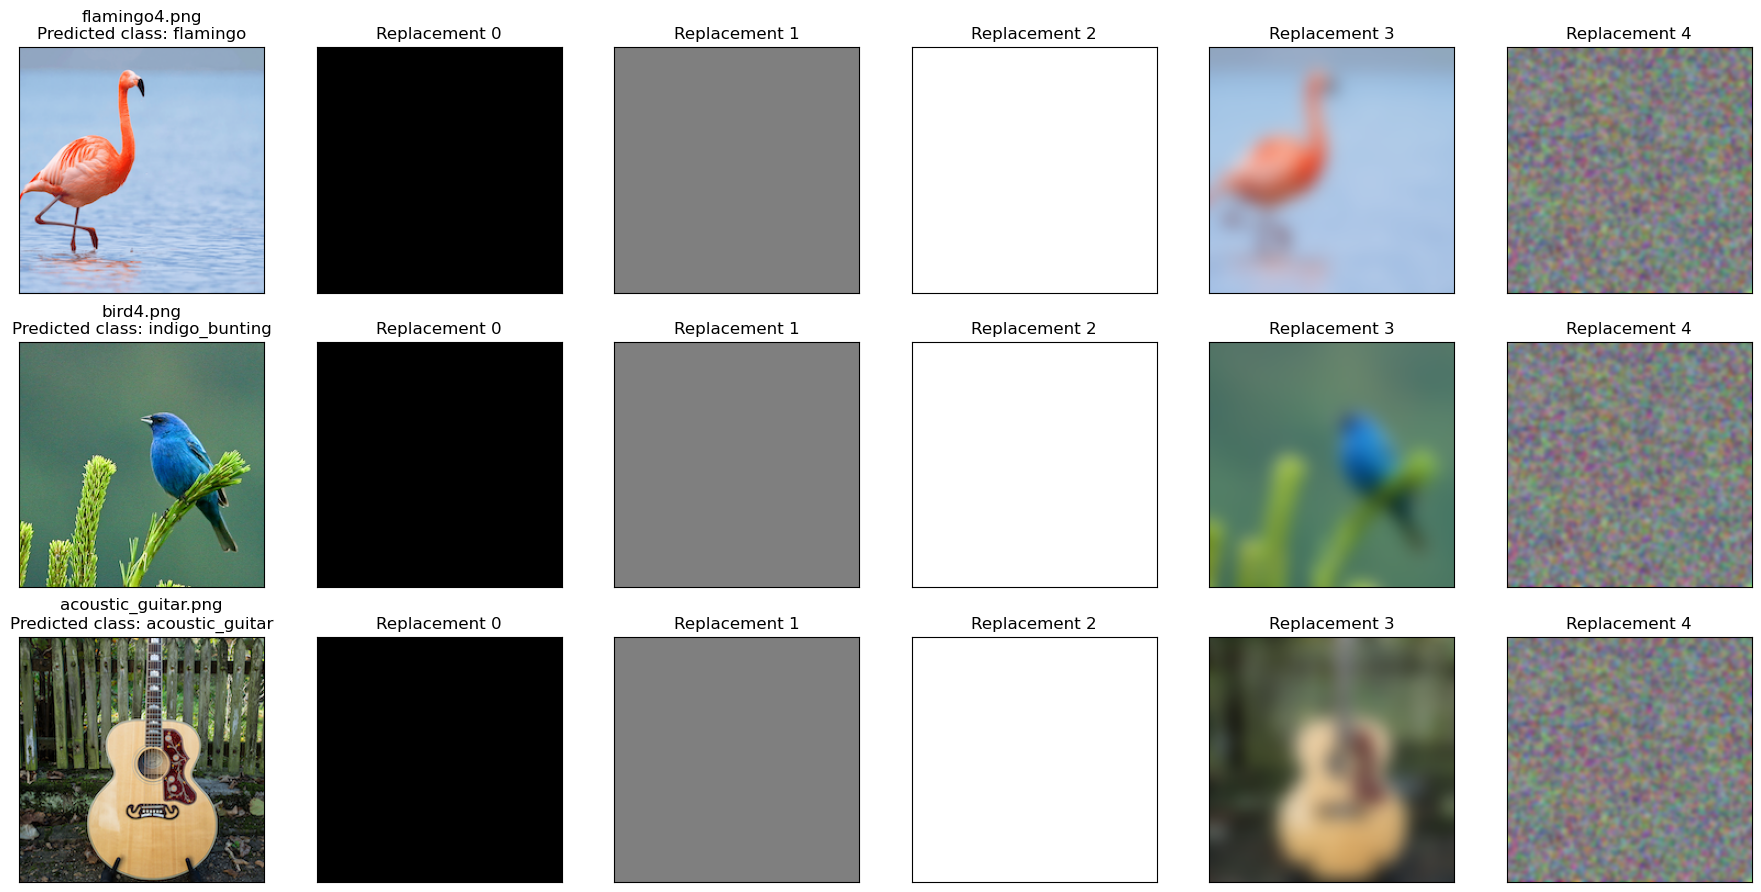

In [8]:
# Show each image (left column) together with its replacement backgrounds (right columns)
num_images = len(image_data_list)
num_bkgnds = 5  # we defined exactly 5 backgrounds earlier

fig, axes = plt.subplots(
    num_images, 
    1 + num_bkgnds,
    figsize=(3 * (1 + num_bkgnds), 3 * num_images)
)

# Ensure axes is 2D even when num_images == 1
if num_images == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, data in enumerate(image_data_list):
    # Original image
    img = data["image_np"]
    cls_id = data["predicted_class"]
    axes[row_idx, 0].imshow(img)
    axes[row_idx, 0].set_title(
        f"{data['image_path']}\nPredicted class: {class_names[cls_id]}"
    )
    axes[row_idx, 0].set_xticks([])
    axes[row_idx, 0].set_yticks([])
    
    # Replacement backgrounds
    bkgnd_imgs = data["background_image_set"]  # shape (5, H, W, 3)
    
    for col_idx in range(num_bkgnds):
        axes[row_idx, col_idx + 1].imshow(bkgnd_imgs[col_idx].astype(np.uint8))
        axes[row_idx, col_idx + 1].set_title(f"Replacement {col_idx}")
        axes[row_idx, col_idx + 1].set_xticks([])
        axes[row_idx, col_idx + 1].set_yticks([])

plt.tight_layout()
plt.show()

## Configure explanation parameters

In [9]:
# How many black-box evaluations we are willing to pay for the explanation
MAX_EVALS_BUDGET = 100

# Batch size for evaluations within shap_bpt
batch_size = 4

# Number of top classes to explain (here: explain top-4 classes)
num_explained_classes = 4

## Run shap_bpt with method = "BPT" (Binary Partition Tree)

In [10]:
explainers = []
shap_values_list = []

for data in image_data_list:
    print(f"\n=== Explaining {data['image_path']} ===")

    # Create a shap_bpt explainer for this specific image
    explainer = shap_bpt.Explainer(
        data["nu_masked"],
        data["image_np"],
        num_explained_classes=num_explained_classes,
        verbose=True,
    )

    # Compute Owen values using the BPT method
    shap_values = explainer.explain_instance(
        MAX_EVALS_BUDGET,
        method="BPT",
        batch_size=batch_size,
    )

    explainers.append(explainer)
    shap_values_list.append(shap_values)

    # Sanity check: Owen values sum to nu(S) − nu(∅)
    print('Expected Shapley explanation: ', explainer.base_f_S[0] - explainer.base_f_0[0])
    print('Computed Shapley explanation: ', np.sum(shap_values[0]))



=== Explaining flamingo4.png ===


  0%|          | 0/100 [00:00<?, ?it/s]

Expected Shapley explanation:  6.482598960399628
Computed Shapley explanation:  6.482598960399629

=== Explaining bird4.png ===


  0%|          | 0/100 [00:00<?, ?it/s]

Expected Shapley explanation:  6.265199840068817
Computed Shapley explanation:  6.265199840068817

=== Explaining acoustic_guitar.png ===


  0%|          | 0/100 [00:00<?, ?it/s]

Expected Shapley explanation:  5.936330497264862
Computed Shapley explanation:  5.936330497264861


## Visualize the Owen values


Plotting explanations for flamingo4.png


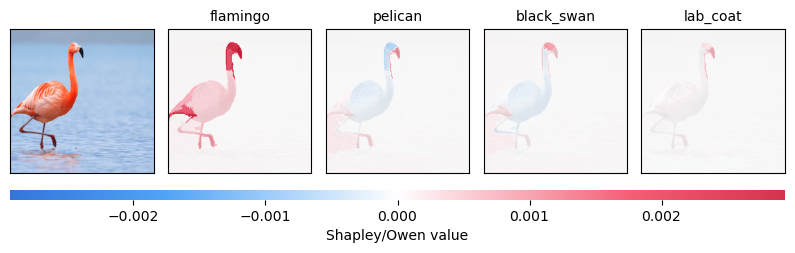


Plotting explanations for bird4.png


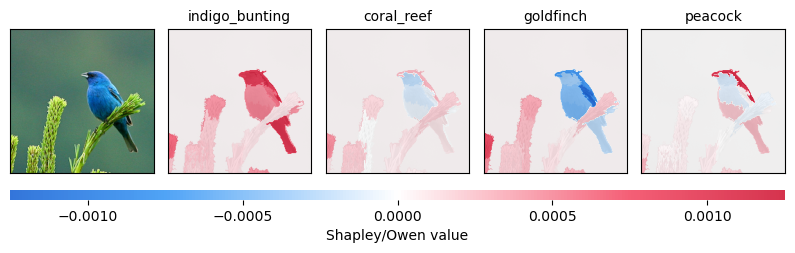


Plotting explanations for acoustic_guitar.png


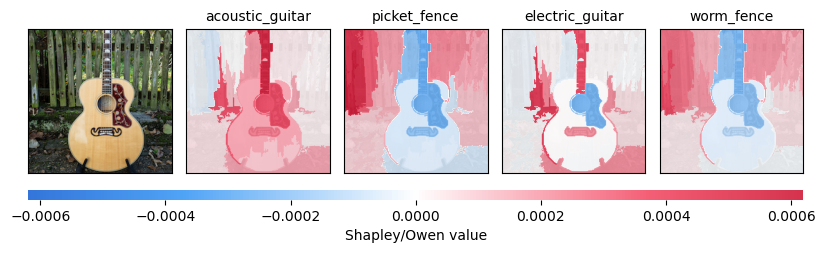

In [11]:
# Plot the Owen value explanations for each image in turn.
# Each call produces its own figure; they will appear one after another.

for data, explainer, shap_values in zip(image_data_list, explainers, shap_values_list):
    print(f"\nPlotting explanations for {data['image_path']}")
    shap_bpt.plot_owen_values(explainer, shap_values, class_names)
